# Continuous optimization - Shifted Sphere - dimension 500

## Importing libraries

In [34]:
import pickle
import pandas as pd
import os
import numpy as np

import os
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy import optimize

In [35]:
funcs = {"sphere": 0, "schwefel": 1, "rosenbrock": 2, "rastrigin": 3, "griewank": 4, "ackley": 5}
funcs_dispname = {"sphere": "F1 : Shifted Sphere Function",
                  "schwefel": "F2 : Schwefel’s Problem 2.21",
                  "rosenbrock": "F3 : Shifted Rosenbrock’s Function",
                  "rastrigin": "F4 : Shifted Rastrigin’s Function",
                  "griewank": "F5 : Shifted Griewank’s Function",
                  "ackley": "F6 : Shifted Ackley’s Function"}

## Open and extract the function data

In [36]:
path = '../data/'
export_path = '../data/'


with open(path +'data.txt','r') as file:
    lines = file.readlines()

j=0
while j < len(lines):
    if lines[j][0:5] == '#endif':
        break
    if lines[j][0:6] == 'double':
        pb_name = lines[j].split(' ')[1].split('[')[0]
        if (pb_name != 'f_bias'):
            j += 1 # increment line
            list_values= []
            while ('}' in lines[j]) == False:
                line = lines[j].strip()
                if len(line) > 0:
                    numbers = line.split(',')
                    numbers2 = [float(i.strip()) for i in numbers if len(i) > 0]
                    list_values += numbers2
                j += 1
        else:
            list_values = []
            print(j)
            numbers = lines[j].split('{')[1].split('}')[0]
            n = len(numbers)
            li2 = numbers[1:n].split(',')
            numbers2 = [float(i.strip()) for i in li2]
            list_values += numbers2
            j += 1
        df = pd.DataFrame(list_values)
        df.to_csv(str(export_path) + str(pb_name) +'.csv', header=['List_values'], index=False)
        print("function %s composed of %d values have been exported to %s" %(pb_name,len(list_values),pb_name+'.csv'))
    j += 1


function sphere composed of 1000 values have been exported to sphere.csv
function schwefel composed of 1000 values have been exported to schwefel.csv
function rosenbrock composed of 1000 values have been exported to rosenbrock.csv
function rastrigin composed of 1000 values have been exported to rastrigin.csv
function griewank composed of 1000 values have been exported to griewank.csv
function ackley composed of 1000 values have been exported to ackley.csv
81
function f_bias composed of 6 values have been exported to f_bias.csv


**Remark** : We created by hand a file called **interval.csv**.

In [50]:
def read_values(func_name):
    values_path = str(path) + str(func_name) + '.csv'
    bias_path = str(path) + 'f_bias.csv'
    interval_path = str(path) + 'interval.csv'

    func_df = pd.read_csv(values_path)
    bias_df = pd.read_csv(bias_path)
    interval_df = pd.read_csv(interval_path,sep=';')

    funcval = func_df.List_values.values
    funcbias = bias_df.List_values.values[funcs[func_name]]
    search_space = list(interval_df.iloc[funcs[func_name],1:3])
    return funcval, funcbias, search_space


@jit(nopython=True)
def eval_cost(x, dim):
    if func_name == "sphere":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z * z
        result = F + funcbias
    elif func_name == "schwefel":
        F = abs(x[0] - funcval[0])
        for i in range(1, dim - 1):
            z = x[i] - funcval[i]
            F = max(F, abs(z))
        result = F + funcbias
    elif func_name == "rosenbrock":
        F = 0
        y = np.empty(dim)
        for i in range(dim - 1):
            y[i] = x[i] - funcval[i] + 1
        for i in range(dim - 2):
            F += 100 * ((y[i] ** 2 - y[i + 1]) ** 2) + (y[i] - 1) ** 2
        result = F + funcbias
    elif func_name == "rastrigin":
        F = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F += z ** 2 - 10 * math.cos(2 * math.pi * z) + 10
        result = F + funcbias

    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += math.cos(z / math.sqrt(i + 1))
        result = F1 - F2 + 1 + funcbias
    elif func_name == "ackley":
        Sum1 = 0
        Sum2 = 0
        for i in range(dim - 1):
            z = x[i] - funcval[i]
            Sum1 += z ** 2
            Sum2 += math.cos(2 * math.pi * z)
        result = -20 * math.exp(-0.2 * math.sqrt(Sum1 / dim)) - math.exp(Sum2 / dim) + 20 + math.e + funcbias
    else:
        result = 0

    return result


def optimize_minimize(dim, x0, search_space, method, options):
#     fitness_per_eval=[]
    def f(x, dim):
        result = abs(eval_cost(x, dim) - funcbias)
        fitness_per_eval.append(result)
        return result

    t1 = time.time()
    result = optimize.minimize(f, args=(dim), x0=cur_x, method=method, options=options)
    t2 = time.time()

    return result, t2 - t1, fitness_per_eval


# function to make print report of function solving

def print_solution(dimension, method, options, result, log, duration):
    algorithm_name = method
    parameters = options
    solution_x = result.x
    fitness = log[-1]
    n_evals = len(log)
    niter = result.nit
    print('-' * 100)
    print("Dimension: %d" % dimension)
    print("Function studied : %s" % funcs_dispname[func_name])
    print("Search Space: ", search_space)
    print("Global Optimum: %.2f\n" % funcbias)
    print('-' * 100)
    print("Chosen algorithm: %s" % algorithm_name)
    print("Parameters: \n%s" % parameters)
    print("Fitness: %f" % fitness)
    print("Solution: ")
    with pd.option_context('display.max_rows', 10):
        print(pd.DataFrame(solution_x, columns=['X']))
    print('-' * 60)
    print("Number of iterations: %d" % n_evals)
    print("Stopping criterion: gtol achieved: %.2e" % options['gtol'])
    print(result.message)
    print("computational time: %.3f seconds" % duration)
    
    plt.figure()
    plt.plot(log)
    plt.xlabel("iterations")
    plt.ylabel("fitness: f(x)-f(x*)")
    plt.savefig("./Results/sol_sphere_500" + ".png")
    plt.show()
    

In [38]:

def plot_func(func_name):
    DIM = 2
    x = np.linspace(search_space[0], search_space[1], 250)
    X = np.meshgrid(x, x)

    if func_name == "sphere":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "schwefel":
        F = np.abs(X[0] - funcval[0]) # initial
        for i in range(1, DIM - 1):
            z = X[i] - funcval[i]
            F = np.max(F, np.abs(z))
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        surf = ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        fig.colorbar(surf, shrink=0.5, aspect=5)
        plt.show()
    elif func_name == "rosenbrock":
        F = 0
        z = np.ndarray(DIM)

        for i in range(DIM - 1):
            z[i] = X[i] - np.ndarray(funcval[i]) + np.ndarray(1)
        for i in range(DIM - 2):
            F += 100 * (z[i + 1] ** 2.0 - z[i] ** 2.0) + (1 - z[i]) ** 2.0
            result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "rastrigin":
        F = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F += z ** 2 - 10 * np.cos(2 * np.pi * z) + 10
        result = F + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "griewank":
        F1 = 0
        F2 = 1
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            F1 += z ** 2 / 4000
            F2 += np.cos(z / np.sqrt(i + 1))
        result = F1 - F2 + 1 + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    elif func_name == "ackley":
        Sum_0 = 0
        Sum_1 = 0
        for i in range(DIM - 1):
            z = X[i] - funcval[i]
            Sum_0 += z ** 2
            Sum_1 += np.cos(2 * math.pi * z)
        result = -20 * np.exp(-0.2 * np.sqrt(Sum_0 / DIM)) - np.exp(Sum_1 / DIM) + 20 + math.e + bias
        fig = plt.figure(figsize=(16, 8))
        ax = fig.add_subplot(1, 1, 1, projection='3d')
        ax.plot_surface(X[0], X[1], result, rstride=5, cstride=5, cmap='jet', alpha=.4, edgecolor='none')
        plt.show()
    else:
        result = 0

## Compare & run & choose the algorithm by printing its fitness function

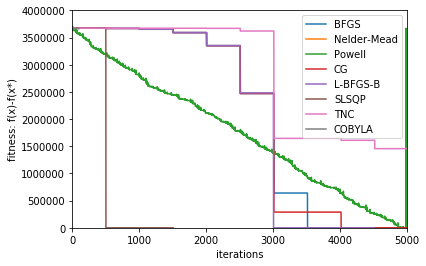

In [48]:
func_name = 'sphere'
funcval, funcbias, search_space = read_values(func_name)
DIM = 500

xmin, xmax = search_space
x_min = xmin * np.ones(DIM)
x_max = xmax * np.ones(DIM)
cur_x = np.random.uniform(min(x_min), max(x_max), (1, DIM))

from copy import deepcopy
j=0

fitness_per_eval = []
options = {'maxiter': 100, 'disp': False}

model= ['BFGS','Nelder-Mead','Powell','CG','L-BFGS-B','SLSQP','TNC','COBYLA'] #,'trust-ncg'
list3=len(model) * [0]
for m in model:
    sol = optimize_minimize(DIM,cur_x, search_space, m, options)
    sol2=sol[2]
    list3[j] = deepcopy(sol2)
    j=j+1

l=[0]
for j in list3:
    l.append(len(j))

# %matplotlib inline
    
for m in range(len(model)):
    plt.plot(list3[m][l[m]:l[m+1]], label=model[m])
    plt.xlabel("iterations")
    plt.ylabel("fitness: f(x)-f(x*)")
    plt.xlim(0,5000)
    plt.ylim(0,0.4*10**7)
    plt.legend()
plt.savefig("./Results/comp_sphere_500.png")
plt.show()


BFGS seems to be adpated for this problem. 

## Apply the more adapted algorithm

----------------------------------------------------------------------------------------------------
Dimension: 50
Function studied : F1 : Shifted Sphere Function
Search Space:  [-100, 100]
Global Optimum: -450.00

----------------------------------------------------------------------------------------------------
Chosen algorithm: BFGS
Parameters: 
{'maxiter': 100, 'gtol': 1e-05, 'disp': False}
Fitness: 0.000000
Solution: 
             X
0    97.249939
1    77.060987
2   -19.031147
3    25.428699
4   -22.908801
..         ...
495   0.469896
496  56.368823
497 -66.902334
498  73.065521
499 -87.339106

[500 rows x 1 columns]
------------------------------------------------------------
Number of iterations: 5020
Stopping criterion: gtol achieved: 1.00e-05
Optimization terminated successfully.
computational time: 0.305 seconds


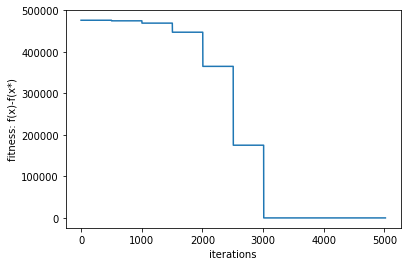

In [51]:
func_name = 'sphere'
funcval, funcbias, search_space = read_values(func_name)

fitness_per_eval = []
DIM = 50
method = 'BFGS' # Chosen algorithm
options = {'maxiter': 100, 'gtol': 1e-5, 'disp': False}

result, duration, logs = optimize_minimize(DIM, cur_x, search_space, method, options)
print_solution(dimension=DIM, method=method, options=options, result=result, log=logs, duration=duration)
